# Westeros Tutorial Part III - Introducing emission taxes

In the second part, we showed how to introduce emissions into a stylized energy systems model, and what happens if you put a constraint on total CO2 emissions.

Now, we will tackle the complementary policy to emissions constraints, namely emissions taxes.

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [2]:
mp = ixmp.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at '/Users/BintangYuwono/.local/share/ixmp/localdbdefault'


In [3]:
model = 'Westeros Electrified'
base = message_ix.Scenario(mp, model=model, scenario='baseline')

## Load the scenario with an emission bound and look at the result in more detail

In [4]:
scen_bd = message_ix.Scenario(mp, model=model, scenario='emission_bound')

In [5]:
emissions = scen_bd.var('EMISS', {'node': 'Westeros'})
emissions

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,7664.400879,0.0
1,Westeros,CO2,all,710,9501.081055,0.0
2,Westeros,CO2,all,720,6834.517578,0.0


In [6]:
emission_prices = scen_bd.var('PRICE_EMISSION')
emission_prices

,node,type_emission,type_tec,year,lvl,mrg
0,Westeros,GHG,all,700,1.623407,0.0
1,Westeros,GHG,all,710,2.644359,0.0
2,Westeros,GHG,all,720,4.307382,0.0


When setting a cumlulative bound, the optimization model choses an emission trajectory that pushes the cost towards the  end of the model horizon. As a consequence, the shadow price or dual variable of the constraint increase exponentially at the discount rate.

## Make a new scenario with emission bounds by year

In the previous example, we imposed a bound on emissions over the entire model horizon by using the `type_year 'cumulative'`. Now, we will create a similar scenario, but the constraint will be defined per year.

For the sake of comparison, the per-year emission values will be chosen exactly in line with the optimal emission trajectory from the previous scenario.

In [7]:
scen_bd_by_year = base.clone(model, 'carbon_bound_by_year','introducing a carbon tax',
                             keep_solution=False)
scen_bd_by_year.check_out()

In [8]:
scen_bd_by_year.add_set('emission', 'CO2')
scen_bd_by_year.add_cat('emission', 'GHG', 'CO2')
scen_bd_by_year.add_par('emission_factor', scen_bd.par('emission_factor'))

In [9]:
base_bd_emission = {
    'node': 'Westeros',
    'type_year': [700, 710, 720],
    'type_tec': 'all',
    'unit': 'tCO2',
    'type_emission': 'GHG',
    'value': emissions.lvl
}

bd_emission = make_df(base_bd_emission)
scen_bd_by_year.add_par('bound_emission', bd_emission)

In [10]:
scen_bd_by_year.commit(comment='emission bound by year')

In [11]:
scen_bd_by_year.solve()

In [12]:
emission_prices_by_year = scen_bd_by_year.var('PRICE_EMISSION')
emission_prices_by_year

,node,type_emission,type_tec,year,lvl,mrg
0,Westeros,GHG,all,710,4.726496,0.0
1,Westeros,GHG,all,720,4.307382,0.0


Comparing the emission prices between the two scenarios, we see that the values are identical in the year 710 and close in the year 720. However, the bound in the year 700 is not binding, so the shadow price is 0 (and is not shown here).

## Setting an emissions tax instead of a bound

Again, we choose the emissions prices from the first example (with a cumulative bound) as the tax level over time.

In [13]:
scen_tax = base.clone(model, 'carbon_tax','introducing a carbon tax',
                      keep_solution=False)
scen_tax.check_out()

In [14]:
scen_tax.add_set('emission', 'CO2')
scen_tax.add_cat('emission', 'GHG', 'CO2')
scen_tax.add_par('emission_factor', scen_bd.par('emission_factor'))

In [15]:
scen_tax.add_set('type_year', [700, 710, 720])
horizon = scen_tax.set('type_year')
base_tax_emission = {
        'node': 'Westeros',
        'type_emission': 'GHG',
        'type_year': horizon,
        'type_tec': 'all',
        'value': 70.,
        'unit': 'USD/tCO2',
}

tax_emission = make_df(base_tax_emission)
scen_tax.add_par('tax_emission', tax_emission)

In [16]:
scen_tax.commit(comment='setting taxes on emissions')

In [17]:
scen_tax.solve()

In [18]:
scen_tax.var('EMISS', {'node': 'Westeros'})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,5813.749512,0.0
1,Westeros,CO2,all,710,4700.967773,0.0
2,Westeros,CO2,all,720,1034.237183,0.0


Comparing the emissions trajectory in the tax scenario to the outcome in the cumulative budget constraint scenario, we notice that the values in the years 700 and 720 are identical, but the value in 710 is different.

This is the flip side of having an identical shadow price on the constraint in the two previous examples - at that price, the costs between wind and coal (with the tax) are exactly equal, hence the optimal solution is not unique.

This is usually only an issue in small, stylized problems...

## Plotting Results

In [19]:
from tools import Plots
p = Plots(scen_tax, 'Westeros', firstyear=700)

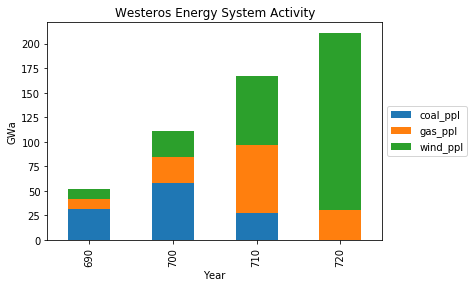

In [20]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

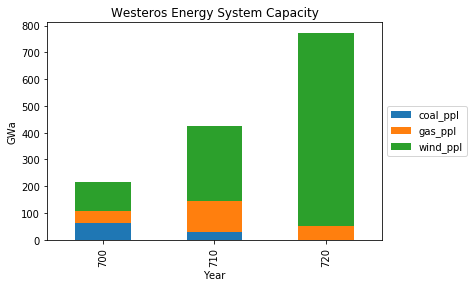

In [21]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

## Close the connection to the database

In [22]:
mp.close_db()